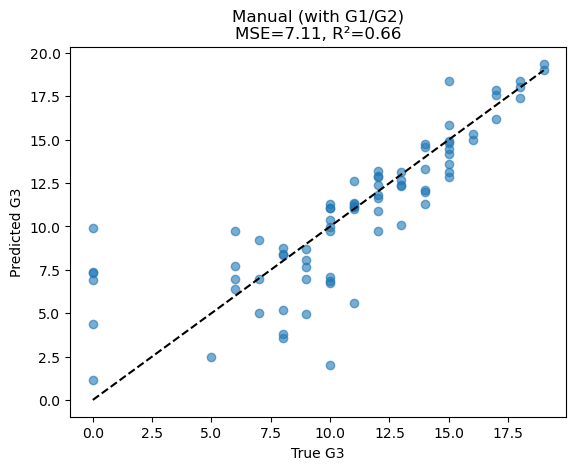

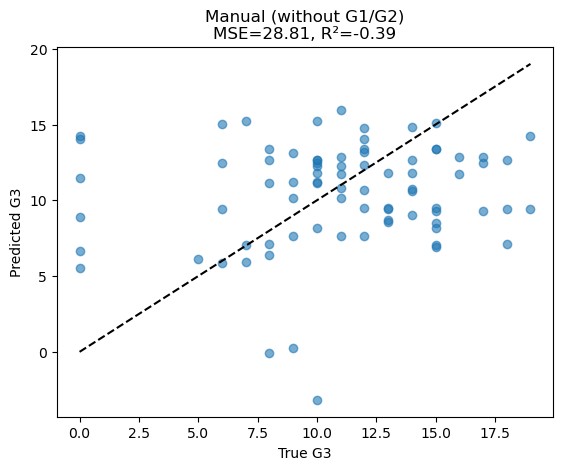

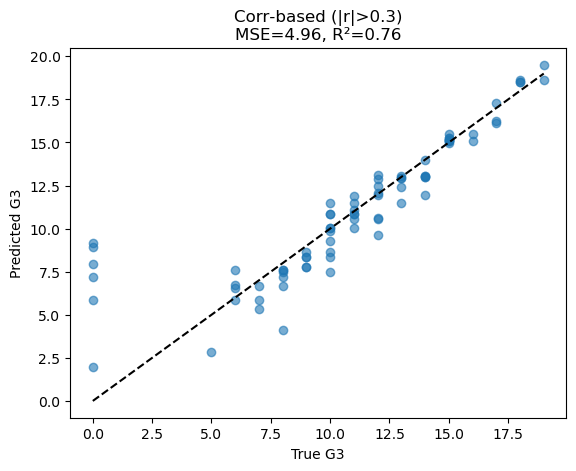

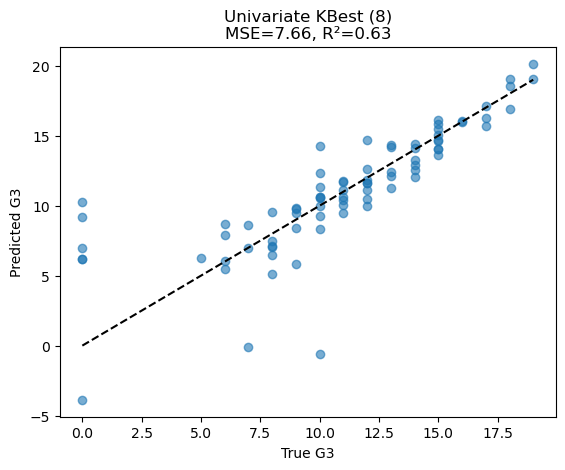

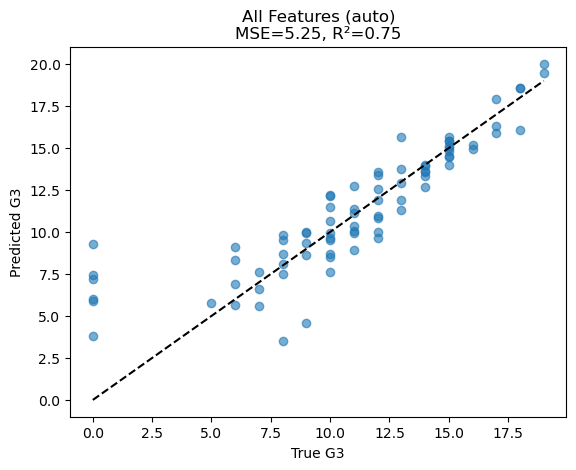

                    Model        MSE        R2
0     Manual (with G1/G2)   7.109692  0.655848
1  Manual (without G1/G2)  28.814284 -0.394784
2    Corr‑based (|r|>0.3)   4.958036  0.760001
3    Univariate KBest (8)   7.664396  0.628997
4            All Features   5.253455  0.745701


In [57]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt


# Load and preprocess
df = pd.read_csv("Math-Students.csv")
df['schoolsup'] = df['schoolsup'].map({'yes':1,'no':0})
df['internet'] = df['internet'].map({'yes':1,'no':0})
y = df['G3']


#Manual feature‑lists
manual_with    = ['G1','G2','Medu','failures','studytime','goout','schoolsup','internet']
manual_without = ['Medu','failures','studytime','goout','schoolsup','internet']

# convert to numeric cols only
numeric_df = df.select_dtypes(include=[np.number])

# corr-related feature set,  build a boolean mask, then convert to a list of names
corrs = numeric_df.corr()['G3'].abs()        # Series of |corr| with G3
mask  = corrs > 0.3       
# drop G3 then take the index (col names) where mask=True
corr_threshold = mask.drop('G3')[mask.drop('G3')].index.tolist()

#selectKBest
X_num = numeric_df.drop(columns=['G3'])
selector = SelectKBest(f_regression, k=8).fit(X_num, y) #top 8 most important features
kbest_feats = X_num.columns[selector.get_support()].tolist()

feature_sets = {
    "Manual (with G1/G2)":     manual_with,
    "Manual (without G1/G2)":  manual_without,
    "Corr‑based (|r|>0.3)":     corr_threshold,
    "Univariate KBest (8)":     kbest_feats
}

results = []
for name, feats in feature_sets.items():

    # one‑hot encode any categoricals
    X = pd.get_dummies(df[feats], drop_first=False)

    # train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

    # pipeline
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPRegressor((50,50), max_iter=5000, random_state=42))
    ])
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    mse = mean_squared_error(y_te, y_pred)
    r2  = r2_score(y_te, y_pred)
    results.append((name, mse, r2))

    # plot
    plt.scatter(y_te, y_pred, alpha=0.6)
    plt.plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()], 'k--')
    plt.title(f"{name}\nMSE={mse:.2f}, R²={r2:.2f}")
    plt.xlabel("True G3"); plt.ylabel("Predicted G3")
    plt.show()

# Using all features
X_full = df.drop(columns=['G3'])
numeric_features = X_full.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_full.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

pipe_all = Pipeline([
    ('pre', preprocessor),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100,50),
                         max_iter=1000,
                         random_state=42))
])

X_tr, X_te, y_tr, y_te = train_test_split(
    X_full, y, test_size=0.2, random_state=42
)
pipe_all.fit(X_tr, y_tr)
y_pred_all = pipe_all.predict(X_te)
mse_all = mean_squared_error(y_te, y_pred_all)
r2_all  = r2_score(y_te, y_pred_all)

results.append(("All Features", mse_all, r2_all))
plt.scatter(y_te, y_pred_all, alpha=0.6)
plt.plot([y_te.min(),y_te.max()],[y_te.min(),y_te.max()],'k--')
plt.title(f"All Features (auto)\nMSE={mse_all:.2f}, R²={r2_all:.2f}")
plt.xlabel("True G3"); plt.ylabel("Predicted G3")
plt.show()

# Summarized
summary = pd.DataFrame(results, columns=["Model","MSE","R2"])
print(summary)